# Evolución en el tiempo ante despeje de una falta trifásica en el punto medio de la línea 2 y que se despeja por apertura de la misma.

In [13]:
# Carga de librerías:
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optim
import sympy

In [14]:
# Datos:
Sgen = 100 # MVA
Ugen = 15 # kV
H = 3 # s
Xgen = 0.3 # pu (transitoria)
Ured = 220 # kV
St = 100 # MVA
Xt = 0.15 # pu
Xl1 = 0.20 # pu
Xl2 = 0.20 # pu
dist_falta = 0.5 # Posición de la falta en la línea (distancia relativa desde cabecera)
FPgen = 0.8 # factor de potencia del generador
Gen = 1 # Régimen de carga del generador (tanto por uno)
f = 50 # Hz
omega_0 = 2*np.pi*f # Velocidad de sincronismo

# Transformación a magnitudes por unidad
Sbase = 100 # Potencia base
Ub1 = Ugen # Tensión base zona 1 (generador)
Ub2 = Ured # Tensión base zona 2 (red)
ugen = Ugen/Ub1
ured = Ured/Ub2
sgen = Sgen/Sbase

D = 5 # pu (actor de amortiguamiento): 5 pu.
t_desp = 0.436832 # s (tiempo de despeje de la falta): 0.436832 s
t_pf = 10 # s (tiempo de simulación postfalta)

In [15]:
# Corriente inyectada por el generador antes de la falta:
sgen_comp = sgen*Gen*(FPgen+cm.sin(np.arccos(FPgen))*1j)
igen = sgen_comp/ugen
igen = igen.conjugate()

# Tensión detrás de la reactancia transitoria del generador respecto de los bornes del mismo:
egen = ugen + Xgen*1j*igen 

# Impedancia de transferencia antes de la falta:
Xe_pref = Xgen + Xt + Xl1*Xl2/(Xl1+Xl2)
print('Xe_pref:',Xe_pref,'pu')

# Impedancia de transferencia en falta:
Xe_f = Xgen + Xt + Xl1 + (Xgen + Xt)*Xl1/(dist_falta*Xl2)
print('Xe_f:',Xe_f,'pu')

# Impedancia de transferencia después de la falta:
Xe_posf = Xgen + Xt + Xl1
print('Xe_posf:',Xe_posf,'pu')

# Tensión del nodo de conexión a red respecto de los bornes del generador:
ured = ugen - (Xt + Xl1*Xl2/(Xl1 + Xl2))*1j*igen

# Ángulo relativo de la tensión detrás de la reactancia transitoria del generador con relación a la tensión del nudo de potencia infinita ANTES DE LA FALTA:
delta_pref = cm.phase(egen) - cm.phase(ured)
print('delta_pref:',delta_pref*180/np.pi,'deg')

# Potencia máxima transmisible PREFALTA:
Pmax_pref = abs(egen)*abs(ured)/Xe_pref
print('Pmax_pref:',Pmax_pref,'pu')

# Potencia máxima transmisible EN FALTA:
Pmax_f = abs(egen)*abs(ured)/Xe_f
print('Pmax_f:',Pmax_f,'pu')

# Potencia máxima transmisible POSTFALTA:
Pmax_posf = abs(egen)*abs(ured)/Xe_posf
print('Pmax_posf:',Pmax_posf,'pu')

# Ángulo de oscilación máxima:
delta_max = np.pi-np.arcsin(sgen_comp.real/Pmax_posf)
print('delta_max:',delta_max*180/np.pi,'deg')

# Potencia mecánica:
Pmec = sgen_comp.real

Xe_pref: 0.5499999999999999 pu
Xe_f: 1.5499999999999998 pu
Xe_posf: 0.6499999999999999 pu
delta_pref: 24.737082932772985 deg
Pmax_pref: 1.9117946222557363 pu
Pmax_f: 0.6783787369294548 pu
Pmax_posf: 1.6176723726779307 pu
delta_max: 150.36072858950016 deg


<IPython.core.display.Javascript object>


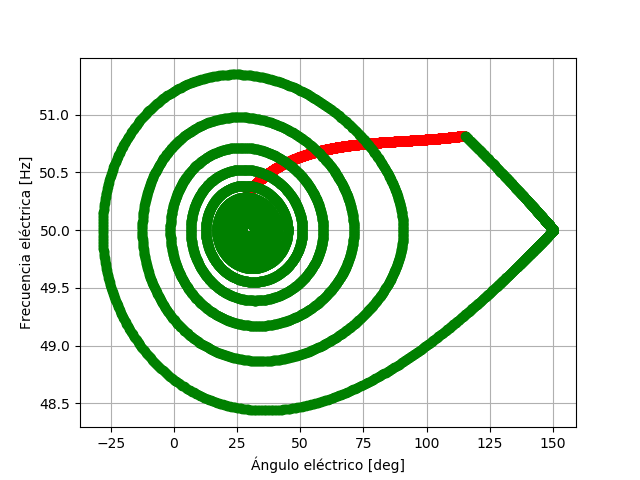

In [19]:
# Resolución en el dominio del tiempo:

# Definimos el sistema de ecuaciones:
# x:delta, y:omega
def f(xy, t, omega_0, H, Pmec, Pmax, D):
    x, y = xy
    f1 = y-omega_0
    f2 = (omega_0/(2*H))*(Pmec-Pmax*np.sin(x)-(D/omega_0)*(y-omega_0))
    return [f1, 
           f2]

# Condición PREFALTA:
# Condición inicial y valores de t:
xy0_pref = [delta_pref, omega_0]
t_pref = np.linspace(0, 1, 10000) # s
# Resolvemos las ecuaciones
xy1_pref = integrate.odeint(f, xy0_pref, t_pref, args=(omega_0,H,Pmec,Pmax_pref, D))
xy1_pref = np.array(xy1_pref)

# Condición EN FALTA:
# Condición inicial y valores de t:
xy0_f = [xy1_pref[-1,0], xy1_pref[-1,1]]
t_f = np.linspace(0, t_desp, 10000) # s
# Resolvemos las ecuaciones
xy1_f = integrate.odeint(f, xy0_f, t_f, args=(omega_0,H,Pmec,Pmax_f, D))
xy1_f = np.array(xy1_f)

# Condición POSTFALTA:
# Condición inicial y valores de t:
xy0_posf = [xy1_f[-1,0], xy1_f[-1,1]]
t_posf = np.linspace(0, t_pf, 10000) # s
# Resolvemos las ecuaciones
xy1_posf = integrate.odeint(f, xy0_posf, t_posf, args=(omega_0,H,Pmec,Pmax_posf, D))
xy1_posf = np.array(xy1_posf)

# Representación gráfica de las soluciones:
# Interacción dinámica con el gráfico creado.
%matplotlib notebook 
plt.ion() # Activa modo interactivo de dibujo
fppre = plt.plot((180/np.pi)*xy1_pref[:,0],xy1_pref[:,1]/(2*np.pi),'bo')
fpf = plt.plot((180/np.pi)*xy1_f[:,0],xy1_f[:,1]/(2*np.pi),'ro')
fppos = plt.plot((180/np.pi)*xy1_posf[:,0],xy1_posf[:,1]/(2*np.pi),'go')
plt.grid() # Malla de la gráfica
plt.ylabel('Frecuencia eléctrica [Hz]')
plt.xlabel('Ángulo eléctrico [deg]')
plt.ioff() # Desactiva modo interactivo de dibujo.

<IPython.core.display.Javascript object>


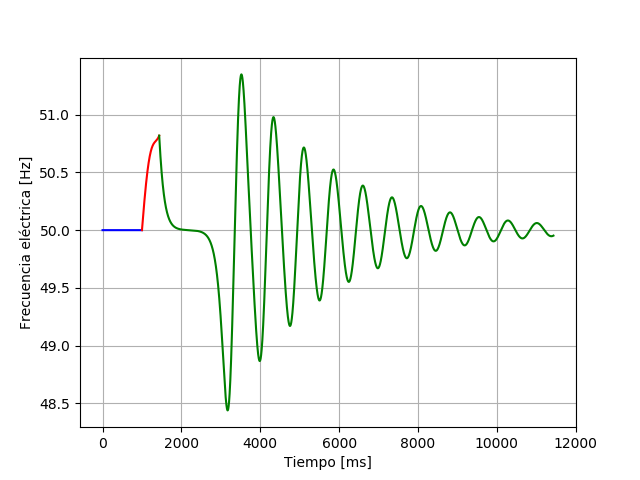

In [20]:
# Representación gráfica de las soluciones:
# Interacción dinámica con el gráfico creado.
%matplotlib notebook 
plt.ion() # Activa modo interactivo de dibujo
ffrecpret = plt.plot(1000*t_pref,xy1_pref[:,1]/(2*np.pi),'b')
ffrecft = plt.plot(1000*(t_pref[-1]+t_f),xy1_f[:,1]/(2*np.pi),'r')
ffrecpost = plt.plot(1000*(t_pref[-1]+t_f[-1]+t_posf),xy1_posf[:,1]/(2*np.pi),'g')
plt.grid() # Malla de la gráfica
plt.ylabel('Frecuencia eléctrica [Hz]')
plt.xlabel('Tiempo [ms]')
plt.ioff() # Desactiva modo interactivo de dibujo.

<IPython.core.display.Javascript object>


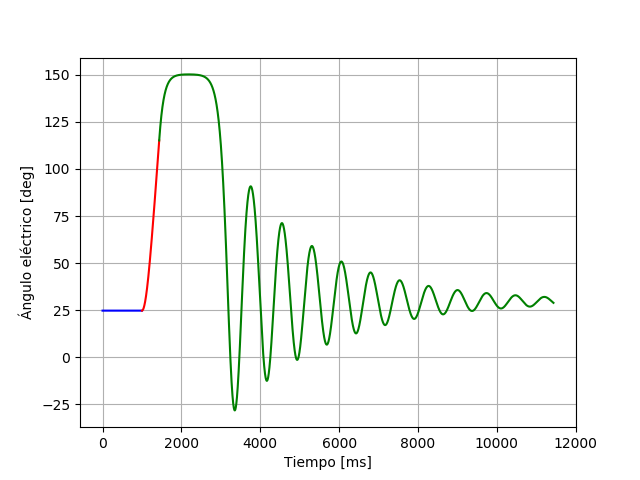

In [18]:
# Representación gráfica de las soluciones:
# Interacción dinámica con el gráfico creado.
%matplotlib notebook 
plt.ion() # Activa modo interactivo de dibujo
fdeltapret = plt.plot(1000*t_pref,(180/np.pi)*xy1_pref[:,0],'b')
fdeltaft = plt.plot(1000*(t_pref[-1]+t_f),(180/np.pi)*xy1_f[:,0],'r')
fdeltapost = plt.plot(1000*(t_pref[-1]+t_f[-1]+t_posf),(180/np.pi)*xy1_posf[:,0],'g')
plt.grid() # Malla de la gráfica
plt.ylabel('Ángulo eléctrico [deg]')
plt.xlabel('Tiempo [ms]')
plt.ioff() # Desactiva modo interactivo de dibujo.